In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import timedelta
import seaborn as sns

In [2]:
charactestics = pd.read_csv('caracteristics.csv', low_memory=False)
holidays = pd.read_csv('holidays.csv', low_memory=False)
places = pd.read_csv('places.csv', low_memory=False)
users = pd.read_csv('users.csv',low_memory=False)

In [3]:
rename_columns = {
    #characterstics
    'Num_Acc':'AccidentID',
    'an':'year',
    'mois':'month',
    'jour':'day',
    'hrmn':'hour',
    'lum':'lighting',
    'agg':'city/countryside',
    'int':'intersection',
    'atm':'atmosphericCondition',
    'col':'collisionType',
    'com':'municipality',
    'adr':'address',
    'gps':'gps_coding',
    'lat':'latitude',
    'long':'longitude',
    'dep':'department',
    #places
    'catr':'roadCategory',
    'voie':'roadNumber',
    'v1':'routeNumber',
    'v2':'routeName',
    'circ':'trafficType',
    'nbv':'numberofLanes',
    'pr':'homePRNumber',
    'pr1':'PRDistance',
    'vosp':'reservedLane',
    'prof':'roadProfile',
    'plan':'laneStructure',
    'lartpc':'centralLaneWidth',
    'larrout':'outerLaneWidth',
    'surf':'surfaceCondition',
    'infra':'infrastructure',
    'situ':'situationofAccident',
    'env1':'schoolPoint',
    #users
    'Acc_number':'AccidentID',
    'place':'place',
    'catu':'userCategory',
    'grav':'severity',
    'sexe' : 'sex',
    'trajet':'reasonForTraveling',
    'secu':'safetyEquipment',
    'locp':'locationOfPedestrian',
    'actp':'actionOfPedestrian',
    'etatp':'pedestrianGroup',
    'an_nais':'yearOfBirth',
    'num_veh':'registrationOfVehicle',
}

charactestics.rename(index=str, columns= rename_columns, inplace=True)
holidays.rename(index=str, columns=rename_columns, inplace=True)
places.rename(index=str, columns=rename_columns, inplace=True)
users.rename(index=str, columns=rename_columns, inplace=True)

In [4]:
#divide by seasons
def season(x):
    if (x>11)or(x<3):
        return 1
    elif (x>8)and(x<12):
        return 3
    elif (x>2)and(x<6):
        return 2
    else:
        return 4


#making date column from year, month and day columns
df = charactestics
date=[]

for i in tqdm(range(0,len(df))):
    tmp = pd.datetime((df.iloc[i,1]+2000),df.iloc[i,2],df.iloc[i,3])
    date.append(tmp)

df["date"] = date
#making period column for seasons
df["period"]=df["month"].apply(lambda x: season(x))


100%|██████████| 839985/839985 [00:22<00:00, 37905.61it/s]


Text(0,0.5,'Number of accidents')

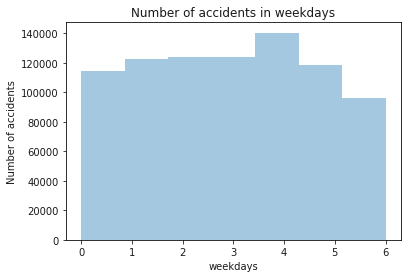

In [5]:
#ploting accident by day of the week
day_of_week = df['date'].dt.dayofweek

ax = sns.distplot(day_of_week,bins=7,kde=False);
sns.set(rc={'figure.figsize':(14,10)})

plt.title('Number of accidents in weekdays')
plt.xlabel('weekdays')
plt.ylabel('Number of accidents')

In [6]:
#making new column, work day or not

work_day=[]
for i in tqdm(range(0,len(df))):
    tmp = df.iloc[i,16] 
    if(tmp.weekday()) in [5,6]:
        work_day.append(2)
    else:
        work_day.append(1)
df['work_day'] = work_day

100%|██████████| 839985/839985 [00:08<00:00, 100047.70it/s]


In [7]:
#missing a lot of data in address, gps_coding, latitude and longtitude
df = df.drop(['address','gps_coding','latitude','longitude'],axis=1)

#we have 'date' for year, month and day 
df = df.drop(['year','month','day'],axis = 1)
#we have ilumination for part of day
df = df.drop(['hour'], axis = 1)
#places with bigger population tend to have more accidents
df = df.drop(['municipality','department'],axis = 1)

In [8]:
df1 = holidays
#print df1.info()
df1.ds= df1.ds.apply(lambda x: pd.to_datetime(x))

holiday_list=[]
for i in tqdm(range(0, len(df1))):
    holiday_list.append(df1.iloc[i,0]-timedelta(days=2))
    holiday_list.append(df1.iloc[i,0]-timedelta(days=1))
    holiday_list.append(df1.iloc[i,0])
    holiday_list.append(df1.iloc[i,0]+timedelta(days=1))
    holiday_list.append(df1.iloc[i,0]+timedelta(days=2))
df["near_holiday"]=df["date"].apply(lambda x: 1 if x in holiday_list else 2)


100%|██████████| 132/132 [00:00<00:00, 1985.98it/s]


In [9]:
df_places = places

#missing a lot of data
df_places = df_places.drop(['routeNumber','routeName','roadNumber','homePRNumber','PRDistance'],axis=1)
#null values
df_places = df_places.drop(['centralLaneWidth','infrastructure','outerLaneWidth','reservedLane','schoolPoint'],axis=1)


In [10]:
#in accordance to Pie-chart
df_places["roadCategory"]=df_places["roadCategory"].apply(lambda x: 5 if x in [5,6,9]  else x)

df_places["Curve"] = df_places["laneStructure"].apply(lambda x: 1 if x in [2,3,4] else 2)

def condition(x):
    if(x in [3,4,5,6,7,8,9]):
        return 3
    else:
        return x
#normal condtion 78%, wet 17%, null/other(oil spill, ice, mud ...) 5%
#making 3 possibilities normal, wet, other
df_places["Condition"] = df_places["surfaceCondition"].apply(lambda x: condition(x))
df_places = df_places.drop(['laneStructure','surfaceCondition'],axis=1)

#making on/off road 
df_places["situationofAccident"] = df_places["situationofAccident"].apply(lambda x:2 if x in [2,3,4,5] else x)
df=pd.merge(df, df_places,on="AccidentID")
df

,AccidentID,lighting,city/countryside,intersection,atmosphericCondition,collisionType,date,period,work_day,near_holiday,roadCategory,trafficType,numberofLanes,roadProfile,situationofAccident,Curve,Condition
0,201600000001,1,2,1,8.0,3.0,2016-02-01,1,1,2,3.0,2.0,0.0,1.0,1.0,1,1.0
1,201600000002,1,2,6,1.0,6.0,2016-03-16,2,1,2,3.0,1.0,0.0,1.0,1.0,1,1.0
2,201600000003,1,1,1,1.0,6.0,2016-07-13,4,1,1,3.0,2.0,2.0,1.0,2.0,1,2.0
3,201600000004,2,2,1,7.0,3.0,2016-08-15,4,1,1,4.0,2.0,0.0,1.0,1.0,2,1.0
4,201600000005,1,2,3,1.0,3.0,2016-12-23,1,1,1,4.0,0.0,0.0,0.0,1.0,2,1.0
5,201600000006,1,2,1,7.0,6.0,2016-12-23,1,1,1,3.0,2.0,0.0,1.0,1.0,2,1.0
6,201600000007,1,2,1,7.0,2.0,2016-05-01,2,2,1,3.0,2.0,0.0,1.0,1.0,2,1.0
7,201600000008,2,1,1,1.0,1.0,2016-05-14,2,2,1,3.0,2.0,2.0,1.0,1.0,2,1.0
8,201600000009,1,2,1,1.0,3.0,2016-09-23,3,1,2,4.0,2.0,2.0,1.0,1.0,2,1.0
9,201600000010,1,1,1,9.0,6.0,2016-12-30,1,1,2,4.0,2.0,0.0,0.0,1.0,2,3.0


In [11]:
df_users = users
#missing lots of data
df_users = df_users.drop(['actionOfPedestrian','locationOfPedestrian','pedestrianGroup'],axis = 1)

#df_users["death"] = df_users["severity"].apply(lambda x: 2 if x in [1,3,4]  else 1)
#df_users = df_users.drop("severity",axis = 1)

#making 3 cases
#with safety equip. 1, without 2 and unknown 3
def equipment(x):
    if(x in [11.0,21.0,31.0,41.0,91.0]):
        return 1
    elif(x in [12.0,22.0,32.0,42.0,92.0]):
        return 2
    elif(x in [13.0,23.0,33.0,43.0,93.0]):
        return 3
df_users["safetyEquipment"] = df_users['safetyEquipment'].apply(lambda x: equipment(x))

#value 9 is others, putting 0 values in other(no known reason for traveling)
def reason(x):
    if(x in [9,0]):
        return 6
    else:
        return x
df_users["reasonForTraveling"] = df_users["reasonForTraveling"].apply(lambda x: reason(x))

df=pd.merge(df, df_users,on="AccidentID")
df.head(10)

,AccidentID,lighting,city/countryside,intersection,atmosphericCondition,collisionType,date,period,work_day,near_holiday,...,Curve,Condition,place,userCategory,severity,sex,reasonForTraveling,safetyEquipment,yearOfBirth,registrationOfVehicle
0,201600000001,1,2,1,8.0,3.0,2016-02-01,1,1,2,...,1,1.0,1.0,1,1,2,6.0,1.0,1983.0,B02
1,201600000001,1,2,1,8.0,3.0,2016-02-01,1,1,2,...,1,1.0,1.0,1,3,1,6.0,1.0,2001.0,A01
2,201600000002,1,2,6,1.0,6.0,2016-03-16,2,1,2,...,1,1.0,1.0,1,3,1,5.0,1.0,1960.0,A01
3,201600000002,1,2,6,1.0,6.0,2016-03-16,2,1,2,...,1,1.0,2.0,2,3,1,6.0,1.0,2000.0,A01
4,201600000002,1,2,6,1.0,6.0,2016-03-16,2,1,2,...,1,1.0,3.0,2,3,2,6.0,1.0,1962.0,A01
5,201600000003,1,1,1,1.0,6.0,2016-07-13,4,1,1,...,1,2.0,1.0,1,1,1,1.0,1.0,1997.0,A01
6,201600000003,1,1,1,1.0,6.0,2016-07-13,4,1,1,...,1,2.0,NaN,3,3,1,5.0,NaN,1970.0,A01
7,201600000004,2,2,1,7.0,3.0,2016-08-15,4,1,1,...,2,1.0,1.0,1,3,1,5.0,3.0,1999.0,B02
8,201600000004,2,2,1,7.0,3.0,2016-08-15,4,1,1,...,2,1.0,2.0,2,4,1,6.0,3.0,1999.0,B02
9,201600000004,2,2,1,7.0,3.0,2016-08-15,4,1,1,...,2,1.0,1.0,1,1,2,6.0,1.0,1985.0,A01


In [12]:
df = df.drop("date",axis = 1)

In [13]:
missingData = df.isnull().sum() / len(df) * 100
df_tmp = pd.DataFrame({'percentage': missingData})
df_tmp = df_tmp.sort_values('percentage',ascending=False)
df_tmp

,percentage
safetyEquipment,6.516507
place,5.349986
numberofLanes,0.216577
roadProfile,0.127878
yearOfBirth,0.125319
Condition,0.123134
situationofAccident,0.121428
trafficType,0.094936
reasonForTraveling,0.019669
atmosphericCondition,0.006183


In [14]:
#drop where missing values
df = df.dropna()

In [15]:
#check for missing data
missingData = df.isnull().sum() / len(df)
tmp = pd.DataFrame({'percentage': missingData})
tmp = tmp.sort_values('percentage',ascending=False)
tmp


,percentage
AccidentID,0.0
lighting,0.0
yearOfBirth,0.0
safetyEquipment,0.0
reasonForTraveling,0.0
sex,0.0
severity,0.0
userCategory,0.0
place,0.0
Condition,0.0


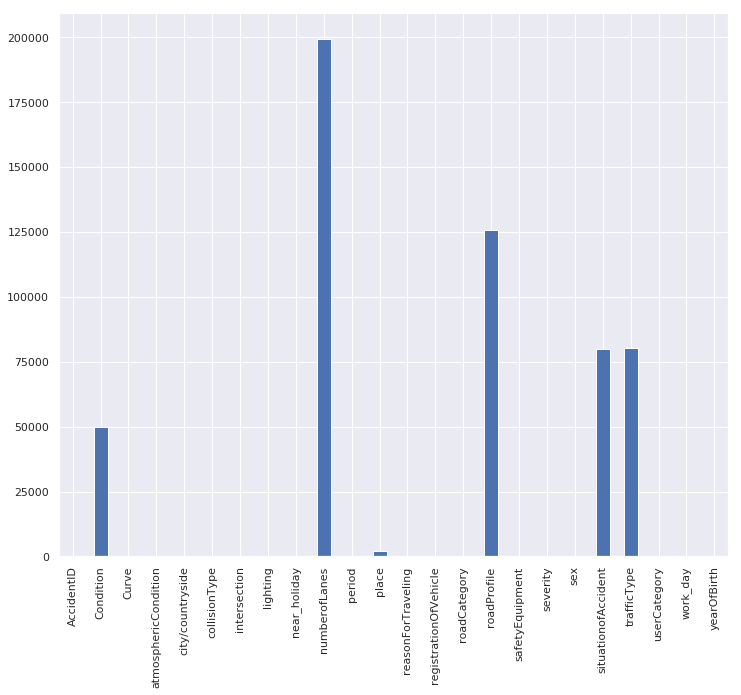

In [16]:
#number of 0 values
tmp = len(df) - df.astype(bool).sum(axis=0) 
tmp.sort_index().plot.bar(figsize=(12,10))

In [17]:
tmp.sort_values(ascending=False)

numberofLanes            199461
roadProfile              125668
trafficType               80446
situationofAccident       79776
Condition                 50040
place                      2173
intersection                214
near_holiday                  0
lighting                      0
city/countryside              0
atmosphericCondition          0
collisionType                 0
period                        0
work_day                      0
registrationOfVehicle         0
roadCategory                  0
yearOfBirth                   0
Curve                         0
userCategory                  0
severity                      0
sex                           0
reasonForTraveling            0
safetyEquipment               0
AccidentID                    0
dtype: int64

In [18]:
#replace 0 values with most common value
df["Condition"] = df["Condition"].replace(0,1)
df["roadProfile"] = df["roadProfile"].replace(0,1)
df["situationofAccident"] = df["situationofAccident"].replace(0,1)
df["trafficType"] = df["trafficType"].replace(0,2)
df["safetyEquipment"] = df["safetyEquipment"].replace(0,3) #3 not known if safety Eq used

avg = df["yearOfBirth"].sum()/len(df)
print avg
df["yearOfBirth"] = df["yearOfBirth"].replace(0,int(avg))
#place will be droped because of correlation with userCategory
#number of lanes = 0 is road without central lane

1973.0164975190633


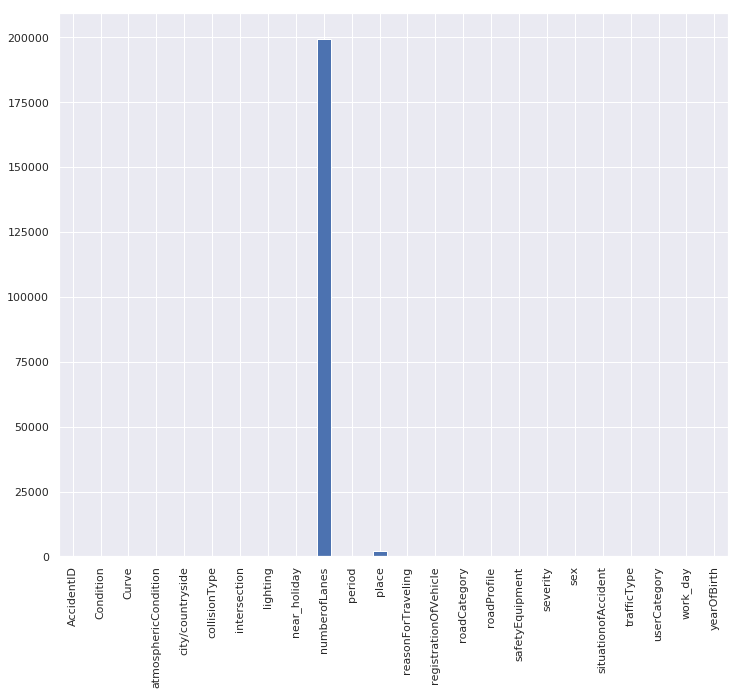

In [19]:
tmp = len(df) - df.astype(bool).sum(axis=0) 
tmp.sort_index().plot.bar(figsize=(12,10))

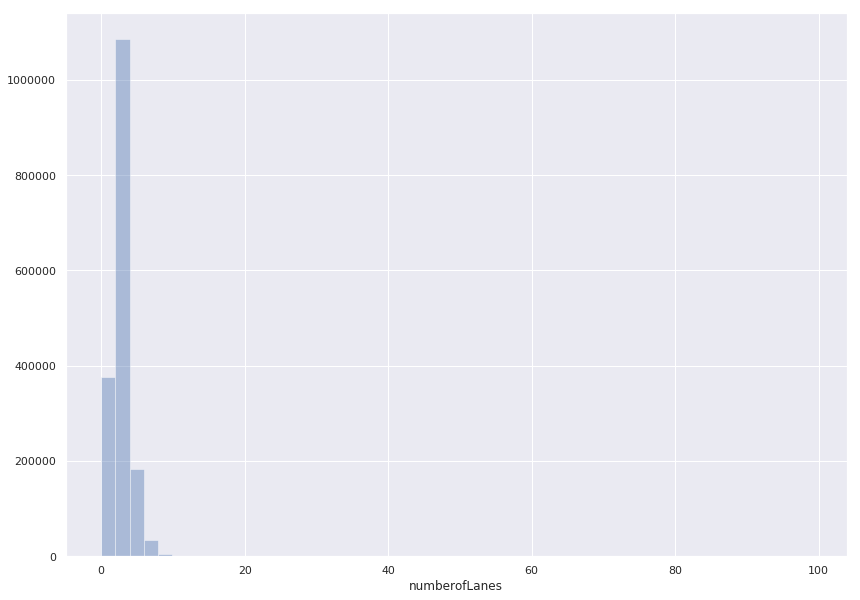

In [20]:
df = df.rename(columns={"city/countryside": "cityOrCountryside"})

ax = sns.distplot(df.numberofLanes,kde=False);
sns.set(rc={'figure.figsize':(14,10)})

#biggest road in Frace has 12 lanes
#anything bigger is outlier
def lanes(x):
    if(x > 12):
        return 12
    else:
        return x
df["numberofLanes"] = df["numberofLanes"].apply(lambda x: lanes(x))


In [21]:
#making age atribute
df["age"] = df["AccidentID"]//100000000 - df["yearOfBirth"].astype(int)
df["age"] = df["age"].apply(lambda x: 16 if (x<17) else x)
df["age"] = df["age"].apply(lambda x: 90 if (x>89) else x)

In [22]:
df = df.drop(["AccidentID","yearOfBirth","registrationOfVehicle"],axis = 1)


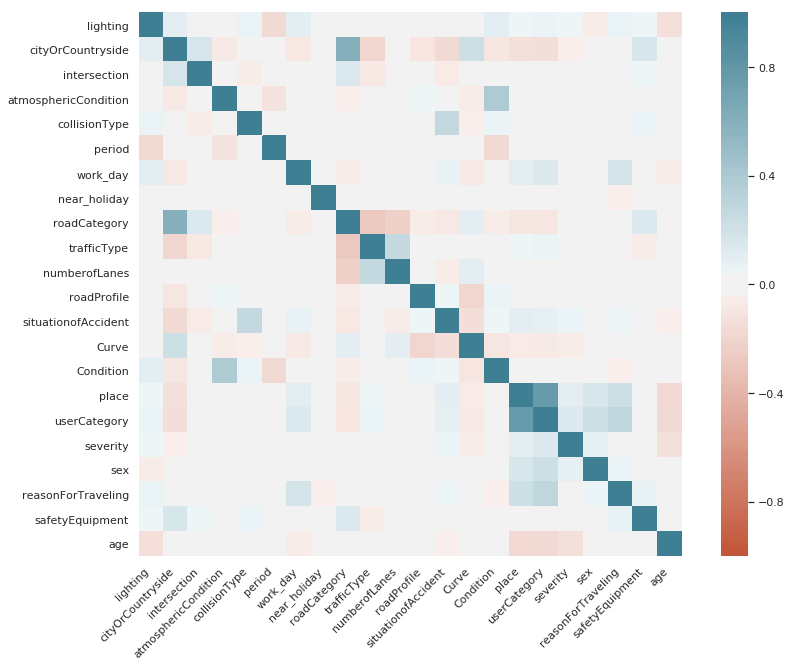

In [23]:
corr = df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
sns.set(rc={'figure.figsize':(18.7,10.27)})
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);


In [24]:
corr

,lighting,cityOrCountryside,intersection,atmosphericCondition,collisionType,period,work_day,near_holiday,roadCategory,trafficType,...,situationofAccident,Curve,Condition,place,userCategory,severity,sex,reasonForTraveling,safetyEquipment,age
lighting,1.000000,0.096481,0.024556,0.030146,0.063309,-0.160194,0.106545,-0.006947,0.035924,-0.009960,...,0.035041,0.009422,0.103459,0.039782,0.056911,0.039604,-0.053153,0.066639,0.046014,-0.136048
cityOrCountryside,0.096481,1.000000,0.179042,-0.077367,0.002181,-0.025483,-0.085903,0.022181,0.605954,-0.193419,...,-0.158923,0.218896,-0.090007,-0.126602,-0.141840,-0.046144,-0.017337,0.001444,0.156873,-0.027711
intersection,0.024556,0.179042,1.000000,-0.008999,-0.049242,-0.004066,-0.021303,0.006289,0.144308,-0.079759,...,-0.068581,0.013861,-0.020511,-0.027764,-0.032488,-0.008407,0.001663,-0.017308,0.046730,0.011387
atmosphericCondition,0.030146,-0.077367,-0.008999,1.000000,0.016187,-0.114693,0.002659,-0.001198,-0.046234,0.021454,...,0.033962,-0.062331,0.389964,0.027041,0.024426,0.000358,0.014578,-0.036033,-0.013856,0.001891
collisionType,0.063309,0.002181,-0.049242,0.016187,1.000000,-0.020805,0.036374,-0.005118,-0.008379,-0.009321,...,0.275617,-0.039853,0.051574,0.019154,0.011102,-0.010782,-0.021608,0.027641,0.047625,-0.027490
period,-0.160194,-0.025483,-0.004066,-0.114693,-0.020805,1.000000,0.006718,0.017898,-0.004377,-0.000478,...,0.008570,-0.020517,-0.171814,0.017743,0.018272,0.007795,-0.005641,0.033408,-0.009268,-0.012876
work_day,0.106545,-0.085903,-0.021303,0.002659,0.036374,0.006718,1.000000,-0.028103,-0.055237,0.018555,...,0.075055,-0.072120,0.006470,0.112691,0.141301,0.030668,0.002822,0.185483,-0.009666,-0.061605
near_holiday,-0.006947,0.022181,0.006289,-0.001198,-0.005118,0.017898,-0.028103,1.000000,0.014194,-0.005688,...,-0.012720,0.016564,0.000277,-0.027646,-0.034253,-0.006889,-0.004013,-0.042768,0.004543,0.009424
roadCategory,0.035924,0.605954,0.144308,-0.046234,-0.008379,-0.004377,-0.055237,0.014194,1.000000,-0.273635,...,-0.081073,0.087667,-0.060349,-0.098338,-0.108189,-0.027681,-0.012197,0.017347,0.141889,-0.023027
trafficType,-0.009960,-0.193419,-0.079759,0.021454,-0.009321,-0.000478,0.018555,-0.005688,-0.273635,1.000000,...,0.031157,0.019042,0.027598,0.041371,0.048441,0.008624,0.012170,0.006289,-0.047993,0.001680


In [25]:
#correlation with userCategory
df = df.drop(["place"],axis = 1)

In [26]:
#df.to_csv('path',index = False)
